In [53]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import time
import csv
import os

# import libraries and functions used for convolution and spatial filters application
from scipy.signal import convolve2d

# import libraries and functions from skimg.morphology
from skimage.morphology import square, dilation, erosion, binary_dilation, binary_erosion, footprint_rectangle, opening, closing
from skimage.io import imread
from skimage.filters import sobel

# import libraries and functions from skimage.transformation
from skimage.transform import hough_line, hough_line_peaks, rotate
from skimage.draw import rectangle_perimeter
from skimage.draw import line
from skimage import color

In [54]:
diretorio = './img/'
# Filtra apenas arquivos de imagem comuns
arquivos = [f for f in os.listdir(diretorio) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Lista para armazenar os recortes (subimagens) para o subplot
subimagens_detectadas = []
estatisticas = []

# Cabeçalho do CSV
header = ['arquivo', 'angulo_detectado', 'tempo_ms', 'largura_px', 'altura_px']

In [55]:
arquivos

['car_01.jpg',
 'car_02.jpg',
 'car_03.png',
 'car_04.png',
 'car_05.png',
 'car_06.png',
 'car_07.jpeg',
 'car_08.jpeg',
 'car_09.jpg',
 'mt_01.png']

In [56]:
for nome_arq in arquivos:
    caminho = './img/'+nome_arq
    
    # Leitura conforme seu padrão
    # img = (io.imread(caminho, as_gray=True) * 255).astype('uint8')
    
    start_t = time.time()
    
    img = (io.imread(caminho, as_gray=True)*255).astype('uint8')

    sobel_img = (sobel(img) * 255).astype('uint8')
    
    limiar = sobel_img.max() * 0.15
    binary_img = sobel_img > limiar
    
    ee = footprint_rectangle((3,3))
    edges = (opening(binary_img,ee)*255).astype('uint8')

    tested_angles = np.linspace(-np.pi/2, np.pi/2, 180, endpoint=False)
    h, theta, d = hough_line(edges, theta=tested_angles)
    h_aux = h.copy()
    h_aux[h_aux<150] = 0

    lines = list()
    for i in range (h_aux.shape[0]):
        for j in range (h_aux.shape[1]):
            if h_aux[i,j]:
                lines.append ((d[i],theta[j]))
    
    angulos = list()
    image_color = color.gray2rgb(edges)

    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0]
            ang = lines[i][1]
            deg = np.rad2deg (ang)
            # ignora angulos não horizontais/verticais
            """if not (np.abs(deg) < 10 or \
                    np.abs (deg - 90) < 10 or \
                    np.abs (deg - 180) < 10):
                continue"""
            angulos.append(ang)
            a = np.cos(ang)
            b = np.sin(ang)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            linha = line (pt1[0],pt1[1],pt2[0],pt2[1])
            for pt in zip (linha[1], linha[0]):
                if 1 <= pt[0] < edges.shape[0]-1 and 0 <= pt[1] < edges.shape[1]:
                    image_color[pt[0], pt[1]] = (0, 0, 255)
                    #print(f"image_color[{pt[0]}, {pt[1]}] = {image_color[pt[0], pt[1]]}")
                    image_color[pt[0]-1, pt[1]] = (0, 0, 255)
                    image_color[pt[0]+1, pt[1]] = (0, 0, 255)

    median_ang = np.median([np.rad2deg(x) for x in angulos])

    if median_ang <= -45:
      final_angle = 90 + median_ang
    elif median_ang >= 45:
      final_angle = median_ang - 90
    else:
      final_angle = median_ang
    

    img_rotated = rotate (img,final_angle)

    rows, cols = edges.shape
    contagem_linhas = []
    contagem_colunas = []
    
    for i in range(rows):
        pixels_brancos = 0
        for j in range(cols):
            if edges[i, j] > 0: 
                pixels_brancos += 1
        contagem_linhas.append(pixels_brancos)
    
    for j in range(cols):
        pixels_brancos = 0
        for i in range(rows):
            if edges[i, j] > 0:
                pixels_brancos += 1
        contagem_colunas.append(pixels_brancos)
    
    
    max_linha = max(contagem_linhas)
    max_coluna = max(contagem_colunas)
    
    y_inicio, y_fim = 0, rows
    x_inicio, x_fim = 0, cols
    
    for i, valor in enumerate(contagem_linhas):
        if valor > max_linha * 0.5:
            y_inicio = i
            break
    for i in range(rows-1, -1, -1):
        if contagem_linhas[i] > max_linha * 0.5:
            y_fim = i
            break
    
    for j, valor in enumerate(contagem_colunas):
        if valor > max_coluna * 0.5:
            x_inicio = j
            break
    for j in range(cols-1, -1, -1):
        if contagem_colunas[j] > max_coluna * 0.5:
            x_fim = j
            break

    # Recorte da subimagem
    recorte = img_rotated[y_inicio:y_fim + 300, x_inicio:x_fim + 100]
    subimagens_detectadas.append(recorte)

    end_t = time.time()
    
    # Salva dados para o CSV
    tempo_ms = (end_t - start_t) * 1000
    estatisticas.append([nome_arq, final_angle, tempo_ms, (x_fim-x_inicio), (y_fim-y_inicio)])

with open('./data/log_processamento.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(estatisticas)

C:\Users\Francisco\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Francisco\anaconda3\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Francisco\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Francisco\anaconda3\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


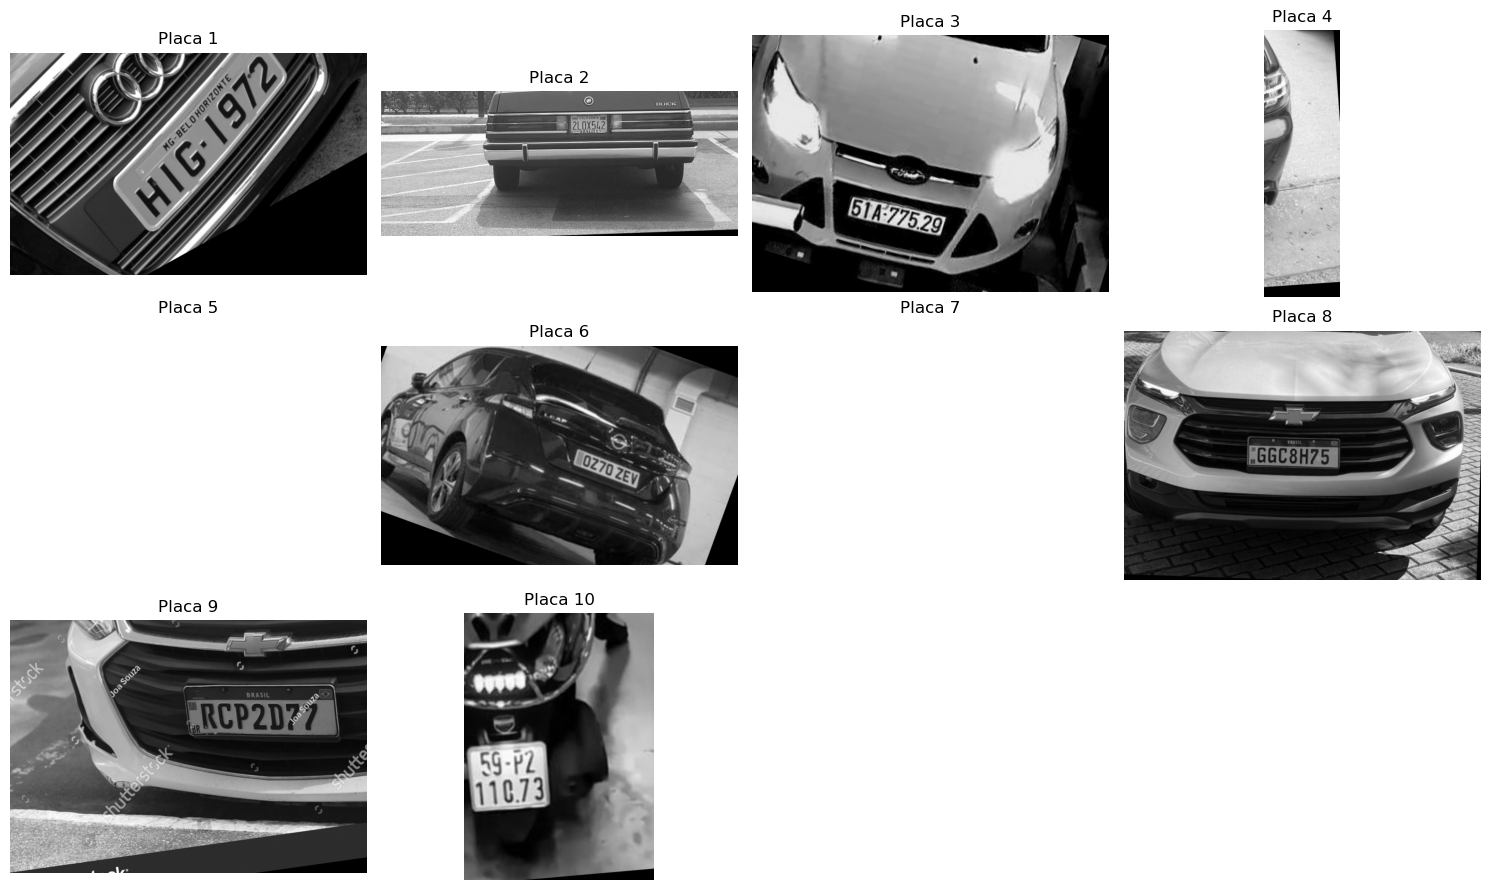

In [57]:
import math

n_imagens = len(subimagens_detectadas)
cols = 4 # Número de colunas no mosaico
rows = math.ceil(n_imagens / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten() # Facilita a iteração

for i in range(n_imagens):
    axes[i].imshow(subimagens_detectadas[i], cmap='gray')
    axes[i].set_title(f"Placa {i+1}")
    axes[i].axis('off')

# Esconde eixos vazios se sobrarem espaços na grade
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()